<a href="https://colab.research.google.com/github/hatttruong/fastai-playbook/blob/main/05_from_scratch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear model and neural net from scratch

### Download data

In [1]:
# !pip install kaggle
#

# DO THE FOLLOWING STEPS TO AVOID ERROR "Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method."
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"hatruong","key":"b3f500767704925a7064052e8d4ef2eb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
import os
from pathlib import Path
import zipfile
import kaggle

In [3]:
# download data from Kaggle
path = Path("titanic")
if not path.exists():
    # kaggle.api.competition_leaderboard_cli(str(path))
    !kaggle competitions download -c titanic --force
    zipfile.ZipFile(f'{path}.zip').extractall(path)

### Setup

In [4]:
import torch
import numpy as np
import pandas as pd

np.set_printoptions(linewidth=140)
pd.set_option('display.width', 140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)

### Clean Data

In [5]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
modes = df.mode()#.iloc[0]
modes

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3.0,"Abbing, Mr. Anthony",male,24.0,0.0,0.0,1601,8.05,B96 B98,S
1,2,NaN,NaN,"Abbott, Mr. Rossmore Edward",NaN,NaN,NaN,NaN,347082,NaN,C23 C25 C27,NaN
2,3,NaN,NaN,"Abbott, Mrs. Stanton (Rosa Hunt)",NaN,NaN,NaN,NaN,CA. 2343,NaN,G6,NaN
3,4,NaN,NaN,"Abelson, Mr. Samuel",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,"Abelson, Mrs. Samuel (Hannah Wizosky)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,NaN,NaN,"de Mulder, Mr. Theodore",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,888,NaN,NaN,"de Pelsmaeker, Mr. Alfons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,889,NaN,NaN,"del Carlo, Mr. Sebastiano",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,890,NaN,NaN,"van Billiard, Mr. Austin Blyler",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note: Read more about iloc & loc at https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/

In [8]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [9]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

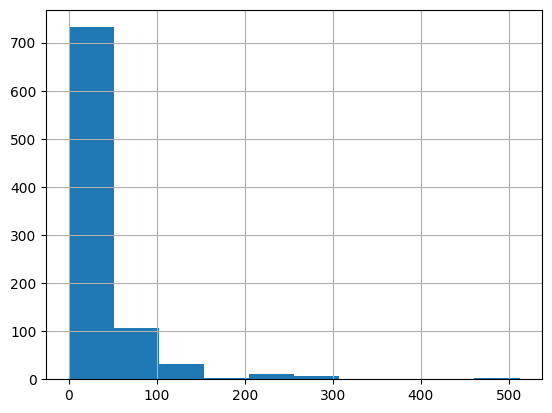

In [11]:
df['Fare'].hist()

<Axes: >

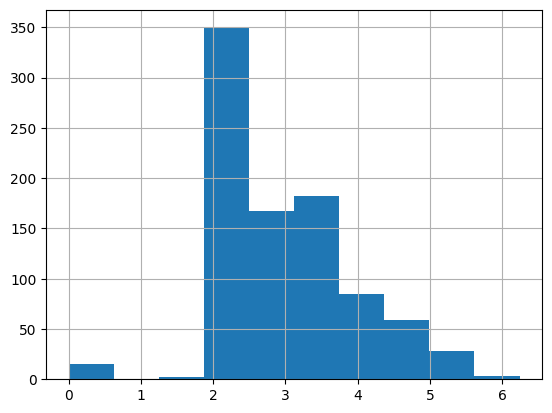

In [12]:
#
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist()

In [13]:
sorted(df['Pclass'].unique())

[1, 2, 3]

In [14]:
df.describe(include=(object))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [15]:
# one-hot vector for categorical columns
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [17]:
added_columns = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
                 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_columns].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


### Prepare Tensor

In [18]:
from torch import tensor

In [19]:
t_dep = tensor(df.Survived)
t_dep.size()

torch.Size([891])

In [20]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_columns
indep_cols

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [21]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 12])

In [22]:
t_indep.shape

torch.Size([891, 12])

In [23]:
len(t_indep.shape) # rank of tensor
# vector is rank 1, matrix is rank 2, scala is rank zero

2

## Setup a linear model

In [24]:
torch.manual_seed(442)

In [25]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5 # move from range [0,1] to [-0.5, 0.5]
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [26]:
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

Since the sum of every row will be dominated by the first column (age), we need to normalize value of all columns into the same range. Here we choose a simple solution which divide all by the max value of each independence

In [27]:
vals, indices = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [28]:
t_indep = t_indep / vals
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [29]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

create a very simple prediction by adding up the rows of the product

In [30]:
preds = (t_indep * coeffs).sum(axis=1)
preds.shape

torch.Size([891])

In [31]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

In [32]:
# calculate the loss using MAE
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5200)

In [33]:
def cal_preds(coeffs, indeps):
    return (indeps * coeffs).sum(axis=1)
def cal_loss(coeffs, indeps, deps):
    return torch.abs(cal_preds(coeffs, indeps) - deps).mean()

## Doing gradient descent

In [34]:
coeffs.requires_grad_()
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [35]:
loss = cal_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [36]:
loss.backward()

In [37]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [38]:
# run this code block mutiple times make coeffs.grad bigger and bigger
loss = cal_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0967,  0.0236, -0.0082, -0.1608, -0.3951,  0.2222, -0.2469, -0.0853,  0.1594, -0.3771, -0.1235,  0.3277])

In [39]:
# to avoid this, reset grad to zero after update
loss = cal_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(cal_loss(coeffs, t_indep, t_dep))

tensor(0.4809)


## Training linear model

In [40]:
from fastai.data.transforms import RandomSplitter

In [41]:
train_split, val_split = RandomSplitter(seed=42)(df)

In [42]:
train_indep, val_indep = t_indep[train_split], t_indep[val_split]
train_dep, val_dep = t_dep[train_split], t_dep[val_split]
len(train_indep), len(val_indep)

(713, 178)

In [43]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [123]:
def epoch(coeffs, lr):
    loss = cal_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f'{loss:.3f}; ')

In [45]:
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [122]:
def train_model(epochs=30, lr=0.1):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        # print(f'\nEpoch: {i}')
        epoch(coeffs, lr)
    return coeffs

In [47]:
coeffs = train_model(epochs=18)

0.518; 
0.504; 
0.491; 
0.480; 
0.468; 
0.456; 
0.445; 
0.433; 
0.422; 
0.411; 
0.400; 
0.389; 
0.379; 
0.368; 
0.358; 
0.349; 
0.341; 
0.334; 


In [48]:
def show_coeffs(coeffs):
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs(coeffs)

{'Age': tensor(-0.3271),
 'SibSp': tensor(0.1184),
 'Parch': tensor(0.2478),
 'LogFare': tensor(-0.0492),
 'Sex_female': tensor(0.0605),
 'Sex_male': tensor(-0.3862),
 'Pclass_1': tensor(0.6994),
 'Pclass_2': tensor(0.3714),
 'Pclass_3': tensor(0.2625),
 'Embarked_C': tensor(-0.1073),
 'Embarked_Q': tensor(0.2510),
 'Embarked_S': tensor(0.2422)}

## Measuring Accuracy

In [49]:
preds = cal_preds(coeffs, val_indep)

In [50]:
preds

tensor([     0.5642,      0.0120,     -0.3458,      0.1197,      0.1042,      0.0787,      0.2195,      0.5387,      0.2404,      0.1487,
            -0.0297,     -0.2951,      0.1385,      0.4585,     -0.0365,      0.3452,      0.2634,      0.5871,      0.0418,      0.4205,
             0.0031,      0.3002,      0.5119,      0.5421,      0.0202,      0.0184,      0.5974,      0.2757,      0.0310,      0.4587,
             0.6622,      0.6258,      0.0235,     -0.0237,      0.5397,      0.6713,      0.3351,      0.5208,      0.0029,      0.4604,
             0.1303,      0.0029,      0.1346,      0.4874,      0.0193,      0.5748,     -0.0198,      0.0594,      0.0127,      0.4585,
             0.3782,      0.2077,      0.1960,     -0.0003,      0.1017,      0.0772,      0.0120,     -0.0361,      0.0152,     -0.0205,
             0.0567,      0.0473,      0.2011,      0.0153,      0.4829,      0.4764,      0.1083,     -0.0665,     -0.0024,      0.4689,
            -0.0051,      0.1781, 

In [51]:
result = val_dep.bool() == (preds > 0.5)
result[:10]

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True, False])

In [52]:
result.float().mean()

tensor(0.7191)

In [53]:
def cal_acc(coeffs):
    return (val_dep.bool() == (cal_preds(coeffs, val_indep) > 0.5)).float().mean()

cal_acc(coeffs)

tensor(0.7191)

## Sigmoid Func

In [54]:
preds[:20]

tensor([ 0.5642,  0.0120, -0.3458,  0.1197,  0.1042,  0.0787,  0.2195,  0.5387,  0.2404,  0.1487, -0.0297, -0.2951,  0.1385,  0.4585,
        -0.0365,  0.3452,  0.2634,  0.5871,  0.0418,  0.4205])

In [55]:
import sympy

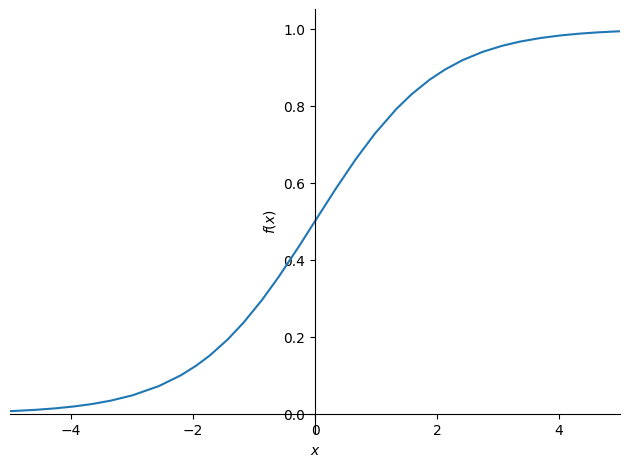

In [56]:
sympy.plot("1/(1 + exp(-x))", xlim=(-5, 5))

In [57]:
def cal_preds(coeffs, indeps):
    return torch.sigmoid((coeffs * indeps).sum(axis=1))

In [58]:
preds = cal_preds(coeffs, val_indep)
preds[:20]

tensor([0.6374, 0.5030, 0.4144, 0.5299, 0.5260, 0.5197, 0.5547, 0.6315, 0.5598, 0.5371, 0.4926, 0.4268, 0.5346, 0.6127, 0.4909, 0.5854,
        0.5655, 0.6427, 0.5105, 0.6036])

In [59]:
coeffs = train_model(lr=100)

0.503; 
0.326; 
0.294; 
0.207; 
0.201; 
0.199; 
0.198; 
0.197; 
0.196; 
0.196; 
0.196; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 


In [60]:
cal_acc(coeffs)

tensor(0.8258)

In [61]:
show_coeffs(coeffs)

{'Age': tensor(-1.5097),
 'SibSp': tensor(-1.1564),
 'Parch': tensor(-0.4253),
 'LogFare': tensor(0.2456),
 'Sex_female': tensor(8.4482),
 'Sex_male': tensor(-10.3873),
 'Pclass_1': tensor(3.8377),
 'Pclass_2': tensor(2.1304),
 'Pclass_3': tensor(-6.2481),
 'Embarked_C': tensor(1.4744),
 'Embarked_Q': tensor(2.1067),
 'Embarked_S': tensor(-4.8086)}

## Improve func cal_preds

In [62]:
# (coeffs * indeps).sum(axis=1) means multiplying elements together then summing up row,
# which is identical to matrix-vector product.
(coeffs * val_indep).sum(axis=1)[:10]

tensor([ 12.3344, -14.8963, -15.5310, -13.2356, -13.4334, -13.7300,   3.6332,   5.3455, -22.1751,   3.1302])

In [63]:
(val_indep@coeffs)[:10,]

tensor([ 12.3344, -14.8963, -15.5310, -13.2355, -13.4334, -13.7300,   3.6332,   5.3455, -22.1751,   3.1302])

In [64]:
def cal_preds(coeffs, indeps):
    return torch.sigmoid(indeps@coeffs)

In [65]:
coeffs = train_model(lr=100)
cal_acc(coeffs)

0.503; 
0.326; 
0.294; 
0.207; 
0.201; 
0.199; 
0.198; 
0.197; 
0.196; 
0.196; 
0.196; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.195; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 
0.194; 


tensor(0.8258)

## A neural network

In [74]:
from torch.nn import functional as F

In [75]:
def init_coeffs(n_hidden=20):
    layer_1 = (torch.rand(n_coeff, n_hidden) - 0.5)/n_hidden
    layer_2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer_1.requires_grad_(), layer_2.requires_grad_(), const.requires_grad_()


In [76]:
l1, l2, const = init_coeffs(n_hidden=10)

In [77]:
l1

tensor([[-0.0415, -0.0196, -0.0135, -0.0141, -0.0091, -0.0333,  0.0087, -0.0270,  0.0163, -0.0227],
        [ 0.0040, -0.0183,  0.0037,  0.0383, -0.0338, -0.0135, -0.0132, -0.0048,  0.0418, -0.0330],
        [ 0.0459,  0.0494,  0.0071,  0.0465,  0.0353,  0.0076,  0.0132,  0.0166,  0.0082, -0.0465],
        [-0.0399, -0.0370, -0.0091, -0.0207,  0.0232, -0.0466, -0.0488,  0.0336, -0.0395,  0.0269],
        [ 0.0437, -0.0099, -0.0264, -0.0071, -0.0471,  0.0348, -0.0212, -0.0068, -0.0291, -0.0209],
        [ 0.0459, -0.0149, -0.0391,  0.0309, -0.0072, -0.0405,  0.0343,  0.0152,  0.0017, -0.0480],
        [ 0.0285,  0.0062,  0.0050, -0.0256,  0.0025, -0.0394,  0.0382,  0.0418,  0.0271, -0.0213],
        [-0.0401, -0.0298,  0.0410, -0.0085, -0.0494,  0.0321, -0.0414, -0.0409,  0.0215, -0.0431],
        [-0.0486,  0.0043, -0.0067, -0.0117,  0.0274, -0.0439, -0.0255,  0.0208,  0.0325, -0.0420],
        [-0.0334, -0.0411,  0.0112,  0.0327, -0.0301,  0.0480,  0.0065,  0.0390,  0.0085, -0.0106],


In [78]:
l2

tensor([[-0.2607],
        [ 0.1333],
        [ 0.3749],
        [ 0.3841],
        [ 0.3731],
        [ 0.2954],
        [-0.2919],
        [ 0.1594],
        [-0.0638],
        [ 0.6604]], requires_grad=True)

In [79]:
const

tensor(0.8294, requires_grad=True)

In [80]:
(train_indep@l1)[:5, ]

tensor([[ 0.0119, -0.0495, -0.0738,  0.0703,  0.0815, -0.0746, -0.0604,  0.0809, -0.0143, -0.0559],
        [-0.0678, -0.0805, -0.0697,  0.0201,  0.0274, -0.0790,  0.0010,  0.0238, -0.0059, -0.1196],
        [-0.0122, -0.0653, -0.0798,  0.0481,  0.0680, -0.0802, -0.0540,  0.0629, -0.0119, -0.0472],
        [-0.0169, -0.0717, -0.0807,  0.0505,  0.0656, -0.0874, -0.0598,  0.0643, -0.0096, -0.0497],
        [ 0.0018, -0.0579, -0.0617,  0.0337,  0.0271, -0.0050, -0.1213,  0.0543, -0.0357, -0.0298]], grad_fn=<SliceBackward0>)

In [81]:
# F.relu: return x if x > 0 else 0
F.relu(train_indep@l1)[:5,]

tensor([[0.0119, 0.0000, 0.0000, 0.0703, 0.0815, 0.0000, 0.0000, 0.0809, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0201, 0.0274, 0.0000, 0.0010, 0.0238, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0481, 0.0680, 0.0000, 0.0000, 0.0629, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0505, 0.0656, 0.0000, 0.0000, 0.0643, 0.0000, 0.0000],
        [0.0018, 0.0000, 0.0000, 0.0337, 0.0271, 0.0000, 0.0000, 0.0543, 0.0000, 0.0000]], grad_fn=<SliceBackward0>)

In [82]:
res = F.relu(train_indep@l1)
(res@l2 + const)[:5, ]

tensor([[0.8966],
        [0.8509],
        [0.8833],
        [0.8835],
        [0.8607]], grad_fn=<SliceBackward0>)

In [83]:
torch.sigmoid(res@l2 + const)[:10]

tensor([[0.7103],
        [0.7008],
        [0.7075],
        [0.7076],
        [0.7028],
        [0.7015],
        [0.6992],
        [0.7075],
        [0.7075],
        [0.7048]], grad_fn=<SliceBackward0>)

In [89]:

def cal_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [117]:
def update_coeffs(coeffs, lr):
    # print("update_coeffs", coeffs)
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [91]:
coeffs = train_model(lr=1.4)

0.544; 
0.537; 
0.532; 
0.526; 
0.519; 
0.512; 
0.504; 
0.495; 
0.486; 
0.476; 
0.465; 
0.455; 
0.444; 
0.434; 
0.426; 
0.418; 
0.412; 
0.407; 
0.403; 
0.400; 
0.397; 
0.395; 
0.393; 
0.391; 
0.390; 
0.389; 
0.388; 
0.387; 
0.387; 
0.386; 


In [94]:
coeffs = train_model(lr=20)

0.544; 
0.464; 
0.387; 
0.382; 
0.381; 
0.380; 
0.380; 
0.380; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 


In [93]:
cal_acc(coeffs)

tensor(0.5955)

## Deep Learning

In [118]:
def init_coeffs():
    hiddens = [10, 10]
    size = [n_coeff] + hiddens + [1] # size of each layer
    n = len(size)
    layers = []
    consts = []
    for i in range(n - 1):
        # init matrix
        layers.append((torch.rand(size[i], size[i+1]) - 0.5)/(size[i+1]))
        consts.append(torch.rand(1)[0] - 0.5)
    for l in layers + consts:
        l.requires_grad_()
    return layers, consts

In [104]:
layers, consts = init_coeffs()
for l in layers: print(l.shape)
print(consts)

torch.Size([12, 10])
torch.Size([10, 10])
torch.Size([10, 1])
[tensor(0.4927, requires_grad=True), tensor(0.4731, requires_grad=True), tensor(-0.3552, requires_grad=True)]


In [119]:
def cal_preds(coeffs, indeps):
    layers, consts = coeffs
    res = indeps
    n = len(layers)
    for i in range(n):
        res = res@layers[i] + consts[i]
        if i != (n - 1):
            res = F.relu(res)
    return torch.sigmoid(res)

In [120]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for l in layers + consts:
        l.sub_(l.grad * lr)
        l.grad.zero_()

In [125]:
coeffs = train_model(lr=4)

0.465; 
0.433; 
0.402; 
0.388; 
0.384; 
0.382; 
0.381; 
0.381; 
0.380; 
0.380; 
0.380; 
0.380; 
0.380; 
0.380; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 
0.379; 


In [126]:
cal_acc(coeffs)

tensor(0.5955)

# Use Framework
